In [1]:
import sys, os
from models import FCN_model
from preprocessing import ConstantLengthDataGenerator
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import mlflow

mlflow.set_experiment("FCN")
mlflow.tensorflow.autolog()

In [2]:
data_path = "./data"
X, y = np.load(f"{data_path}/X.npy", allow_pickle=True), np.load(f"{data_path}/y.npy")
y.shape, X.shape

((60555, 1), (60555,))

In [3]:
mask = np.char.startswith(y, "GunPoint").reshape(-1)
y = y[mask, :]
X = X[mask]
mlflow.log_param("y.unique", np.unique(y))

array(['GunPointAgeSpan_1', 'GunPointAgeSpan_2',
       'GunPointMaleVersusFemale_1', 'GunPointMaleVersusFemale_2',
       'GunPointOldVersusYoung_1', 'GunPointOldVersusYoung_2',
       'GunPoint_1', 'GunPoint_2'], dtype='<U42')

In [4]:
y_encoder = sklearn.preprocessing.OneHotEncoder(categories="auto")
y = y_encoder.fit_transform(y.reshape(-1, 1)).toarray()
mlflow.log_param("y.shape", y.shape)
y.shape, X.shape

((456, 8), (456,))

In [5]:
number_of_classes = y.shape[1]
initial_learning_rate = 1e-4
output_directory = f"{data_path}/models/fcn/outputs"
batch_size = 128
os.makedirs(output_directory, exist_ok=True)

In [6]:
input_layer = keras.layers.Input(shape=(None, 1))
fcn_model = FCN_model(number_of_classes=number_of_classes)(input_layer)
model = keras.models.Model(inputs=input_layer, outputs=fcn_model)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, decay_steps=3, decay_rate=1
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr_schedule),
    metrics=["accuracy"],
    #     run_eagerly=True,
)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, None, 128)         1536      
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 128)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 256)         164096    
                                                                 
 batch_normalization_1 (Batc  (None, None, 256)        1024      
 hNormalization)                                             

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

In [9]:
kwargs = {"min_length": 256, "max_length": 256, "logging_call": mlflow.log_params}
data_generator_train = ConstantLengthDataGenerator(
    X_train, y_train, batch_size=batch_size, **kwargs
)
data_generator_val = ConstantLengthDataGenerator(
    X_val, y_val, batch_size=len(y_val), **kwargs
)

In [10]:
next(data_generator_train)

(array([[-0.973 , -0.9746, -0.9756, ..., -1.01  , -1.009 , -1.007 ],
        [-0.669 , -0.6685, -0.6675, ..., -0.649 , -0.649 , -0.6484],
        [-1.486 , -1.487 , -1.488 , ..., -1.378 , -1.379 , -1.379 ],
        ...,
        [-0.5703, -0.5693, -0.569 , ..., -0.6245, -0.6245, -0.6245],
        [-0.9956, -0.9956, -0.9956, ..., -0.993 , -0.993 , -0.993 ],
        [-1.01  , -1.012 , -1.012 , ..., -1.126 , -1.126 , -1.126 ]],
       dtype=float16),
 array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]))

In [11]:
history = model.fit(
    data_generator_train, epochs=60, validation_data=next(data_generator_val)
)

Epoch 1/60
20/20 [==============================] - 16s 720ms/step - loss: 1.9564 - accuracy: 0.2078 - val_loss: 2.0731 - val_accuracy: 0.1140
Epoch 2/60
20/20 [==============================] - 14s 702ms/step - loss: 1.8512 - accuracy: 0.2875 - val_loss: 2.0646 - val_accuracy: 0.1316
Epoch 3/60
20/20 [==============================] - 14s 673ms/step - loss: 1.7997 - accuracy: 0.2937 - val_loss: 2.0580 - val_accuracy: 0.1930
Epoch 4/60
20/20 [==============================] - 14s 678ms/step - loss: 1.7521 - accuracy: 0.3375 - val_loss: 2.0578 - val_accuracy: 0.1316
Epoch 5/60
20/20 [==============================] - 14s 684ms/step - loss: 1.7559 - accuracy: 0.3340 - val_loss: 2.0680 - val_accuracy: 0.1667
Epoch 6/60
20/20 [==============================] - 13s 660ms/step - loss: 1.7330 - accuracy: 0.3184 - val_loss: 2.0865 - val_accuracy: 0.1579
Epoch 7/60
20/20 [==============================] - 14s 692ms/step - loss: 1.7156 - accuracy: 0.3324 - val_loss: 2.1176 - val_accuracy: 0.1579

Epoch 58/60
20/20 [==============================] - 14s 702ms/step - loss: 1.3247 - accuracy: 0.4289 - val_loss: 1.6022 - val_accuracy: 0.3333
Epoch 59/60
20/20 [==============================] - 15s 736ms/step - loss: 1.3197 - accuracy: 0.4520 - val_loss: 1.8474 - val_accuracy: 0.3509
Epoch 60/60
1/1 [==============================] - 0s 292ms/step


INFO:tensorflow:Assets written to: C:\Users\pacyn\AppData\Local\Temp\tmp90gbrbnu\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\pacyn\AppData\Local\Temp\tmp90gbrbnu\model\data\model\assets
2023/01/22 17:45:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\pacyn\miniconda3\envs\uni\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


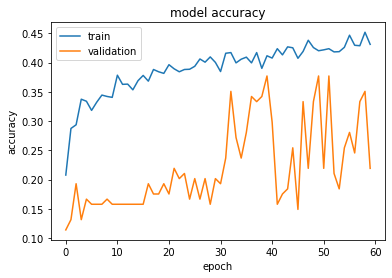

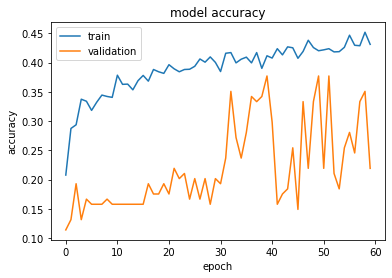

In [12]:
figure = plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
figure

In [13]:
mlflow.log_figure(figure, "data/figures/acc.png")

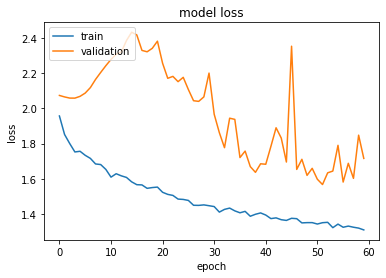

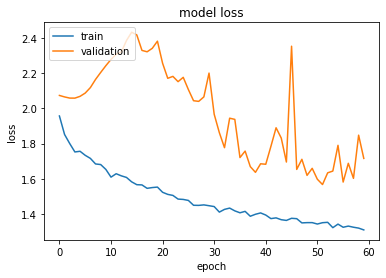

In [14]:
figure = plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
figure

In [15]:
mlflow.log_figure(figure, "data/figures/loss.png")

In [16]:
mlflow.log_artifact("models")
mlflow.log_artifact("preprocessing")

In [17]:
mlflow.end_run()